# MDN_RNN
___
* MDN-RNN output: next latent vector z
* see training params

In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import json

In [3]:
from pathlib import Path
path = str(Path(os.getcwd()).parent)
import_path = str(Path(os.getcwd()).parent.parent)

import sys
sys.path.insert(0,path)
from breakout.rnn.rnn import RNNModel, hps_sample, rnn_init_state
from breakout.vae.vae import ConvVAE

sys.path.insert(0, import_path)
from WorldModelsExperiments.breakout.model import Model, _process_frame

In [3]:
server = True
if server:
    rnn_path = path + '/breakout/results_200218/tf_rnn'
    series_path = path + '/breakout/results_200218/series'
    vae_path = path + '/breakout/results_200218/tf_vae'
    obs_path = path + '/breakout/results_200218/record'
    series_path = path + '/breakout/results_200218/series'


## See MDN-RNN output
from Model()

In [4]:
model = Model(load_model=True, rnn_path=os.path.join(rnn_path, 'rnn.json'), vae_path=os.path.join(vae_path, 'vae.json'))

/home/student/PycharmProjects/worldmodel/venv/lib/python3.6/site-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


INFO:tensorflow:Model using cpu.
model using cpu
input dropout mode = False
output dropout mode = False
recurrent dropout mode = False


FileNotFoundError: [Errno 2] No such file or directory: '/home/student/PycharmProjects/worldmodel/WorldModelsExperiments/breakout/results_200218/tf_rnn/rnn.json'

In [ ]:
series = np.load(os.path.join(series_path,'series.npz'))
data_mu = series['mu']
data_logvar = series['logvar']
data_action = series['action']

In [ ]:
data_mu[0].shape

In [ ]:
z = data_mu[0] + np.exp(data_logvar[0]/2.0) * np.random.randn(*logvar[0].shape)

In [ ]:
z.shape

In [ ]:
z_dec = vae.decode(z[0].reshape(1,32))
z_dec.max()

In [ ]:
data_action[0][0].shape

In [ ]:
state = model.state 

h = np.concatenate([z[0],state.h[0]])

input_x = np.concatenate((z[0].reshape((1, 1, 32)), data_action[0][0].reshape((1, 1, 4))), axis=2)
feed = {
    model.rnn.input_x: input_x,
    model.rnn.initial_state: state
}

[logmix, mean, logstd, next_state] = model.rnn.sess.run([
    model.rnn.out_logmix, model.rnn.out_mean, model.rnn.out_logstd, model.rnn.final_state],
    feed
) # different output from rnn_mdn

In [ ]:
z_dim = 32
chosen_log_pi = np.zeros(z_dim)
chosen_mu = np.zeros(z_dim)
chosen_log_sigma = np.zeros(z_dim)

#adjust temp
pi = np.copy(logmix) #/temperature
logmix2 = np.exp(pi)
logmix2 /= logmix2.sum(axis=1).reshape(z_dim, 1)
logmix2.shape

In [ ]:
from gym.utils import seeding
np_random, seed = seeding.np_random()

In [ ]:
def get_pi_idx(x, pdf):
  # samples from a categorial distribution
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if (accumulate >= x):
            return i
    random_value = np.random.randint(N)
    #print('error with sampling ensemble, returning random', random_value)
    return random_value

In [ ]:
def sample_z(mu, log_sigma):
    z =  mu + (np.exp(log_sigma)) * np_random.randn(*log_sigma.shape) * 0.5
    return z

In [ ]:
for j in range(z_dim):
    idx = get_pi_idx(np_random.rand(), logmix2[j])
    chosen_log_pi[j] = idx
    chosen_mu[j] = mean[j, idx]
    chosen_log_sigma[j] = logstd[j,idx]
    
next_z = sample_z(chosen_mu, chosen_log_sigma)
next_z.shape

In [ ]:
from breakout.vae.vae import ConvVAE
vae = ConvVAE()
vae.load_json(os.path.join(vae_path, 'vae.json'))

next_z = next_z.reshape(1,32)
next_z_decoded = vae.decode(next_z)
next_z_decoded = next_z_decoded.reshape(64,64,3)

plt.imshow(next_z_decoded)
plt.show()

## Training Param

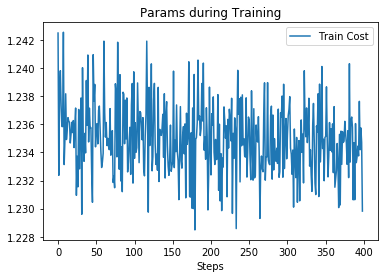

In [5]:
#with open(rnn_path +'/rnn_train_param.json', 'r') as file:
with open('/home/student/PycharmProjects/worldmodel/WorldModelsExperiments/breakout/tf_rnn/rnn_train_param.json', 'r')as file:
    train_param = json.load(file)
train_cost = []
curr_learning_rate = []
for params in train_param:
    train_cost.append(params['train_cost'])
    
plt.plot(train_cost, label='Train Cost')
plt.legend(loc='upper right')
plt.xlabel('Steps')
plt.title('Params during Training')
plt.show()